# Notebook to create dictionary of concepts 
Create a visual dictionary of various concepts from MNIST Data set using the feature maps and latent representations learned by a VAE - Submitted for BMVC2021



# Setup required for colab

In [1]:
%tensorflow_version 1.14.0
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning/
!pwd
env="colab"

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning
/content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!git checkout .
!git pull
# !git diff --name-only

Already up to date.


In [4]:
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"


In [5]:
#import os
from typing import List, DefaultDict, Dict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, load_trained_model, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.dao.dao_factory import get_dao

import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator, DataIterator
from clearn.utils.data_loader import load_images
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.semi_supervised_mnist import SemiSupervisedClassifierMnist
from clearn.config import ExperimentConfig
from matplotlib import pyplot  as  plt
from scipy.special import softmax
from clearn.analysis.encode_decode import decode, decode_and_get_features
from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.analysis import ClusterGroup, Cluster, ManualAnnotation
from clearn.config import ExperimentConfig

%matplotlib inline



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import math
from math import log
import json
from numpy.linalg import norm
import logging

import matplotlib
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_train_val_iterator,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, get_cluster, display_images, segment, segment_multiple_images, cluster_next_level_gmm
from clearn.analysis.cluster_utils import get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_cluster_groups, cluster_next_level_gmm
from PIL import Image

%matplotlib inline


# Experiment Parameters

In [7]:
num_units = [512, 256, 256, 128, 64]
stride_5_layer = [2, 1, 2, 1, 2,  1]
create_split = True
experiment_name = "exp_concepts_1"
num_epochs = 50
run_id = 2
z_dim = 16
train_val_data_iterator = None



In [8]:
layer_num=len(num_units) - 2
label_list = list(range(10,28))
print(label_list)
print(layer_num)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
3


In [9]:
num_second_level_cluster = 10


In [10]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"
num_clusters = 10
num_level_2_clusters = 10

In [11]:
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              num_cluster_config=None,
                              supervise_weight=0,
                              name=experiment_name,
                              z_dim=z_dim,
                              batch_size=1024,
                              beta=5,
                              reconstruction_weight=1,
                              num_units=num_units,
                              save_reconstructed_images=True,
                              split_name="split_70_30",
                              dataset_name="mnist_concepts",
                              eval_interval_in_epochs=4,
                              model_save_interval=10,
                              num_val_samples=-1,
                              run_evaluation_during_training=True,
                              return_latent_vector=False,
                              write_predictions=True,
                              fully_convolutional = True,
                              num_concepts=28,
                              strides=stride_5_layer,
                              activation_output_layer = "SIGMOID",
                              num_dense_layers=0,
                              uncorrelated_features=False,
                              concept_dict = { 6: {"unique_concepts":[-1]},
                                              layer_num:{"unique_concepts":label_list
                                                },
                                              },
                              concept_id=20
                              )
exp_config.check_and_create_directories(run_id)


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


True

In [12]:
_exp_config = exp_config

model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST

In [13]:
_exp_config.concept_dict

{3: {'unique_concepts': [10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27]},
 6: {'unique_concepts': [-1]}}

In [14]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= _exp_config.dao,
                                                 exp_config= _exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=_exp_config.split_name)

train_images, train_labels, _ = load_images(_exp_config,
                                          train_val_data_iterator,
                                          "train"
                                          )
train_labels= np.argwhere(train_labels == 1)[:,1]

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
<class 'numpy.ndarray'> int64
Loaded manual annotation
Number of samples with manual confidence 73414
Warning /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis/manual_annotation.csv path does not exist. Creating random prior with uniform distribution


In [15]:
height, width = train_images.shape[1], train_images.shape[2]
num_training_images = train_images.shape[0]

In [16]:
labels_dict=dict()
cluster_dict = dict()
cluster_dict_level_2 = dict()

In [17]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = _exp_config.dao,
              exp_config=_exp_config,
              model_type=model_type,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = _exp_config.num_train_samples / _exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(1024, 14, 14, 256)
(1024, 14, 14, 256)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 16
in

In [18]:
epochs_completed

46.0

# Read latent vectors

In [19]:
import os
filename  = get_encoded_csv_file(_exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(_exp_config.Z_DIM)
df = pd.read_csv(os.path.join(_exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[df["label"] <= 9] [z_col_names].values
latent_vectors_visual_concepts = df[ (df["label"] > 9) & (df["label"] < 28) ] [z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors for original training images shape",latent_vectors.shape)
print("Latent vectors for visual concepts shape",latent_vectors_visual_concepts.shape)


run_id=2 z_min=-4.2737722 z_max=5.1173835
Latent vectors for original training images shape (41575, 16)
Latent vectors for visual concepts shape (31129, 16)


In [20]:
print(df.columns)

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'mu_10', 'mu_11', 'mu_12',
       'mu_13', 'mu_14', 'mu_15', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3',
       'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8', 'sigma_9',
       'sigma_10', 'sigma_11', 'sigma_12', 'sigma_13', 'sigma_14', 'sigma_15',
       'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9',
       'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'predicted_proba_0',
       'predicted_proba_1', 'predicted_proba_2', 'predicted_proba_3',
       'predicted_proba_4', 'predicted_proba_5', 'predicted_proba_6',
       'predicted_proba_7', 'predicted_proba_8', 'predicted_proba_9',
       'predicted_proba_10', 'predicted_proba_11', 'predicted_proba_12',
       'predicted_proba_13', 'predicted_proba_14', 'predicted_proba_15',
       'predicted_proba_16', 'predicted_proba_17', 'predicted_proba_18',
       'predicted_proba_19', 'predicted

In [21]:
MAX_IMAGES_TO_DISPLAY=36

In [22]:
def get_digit_label(cluster_name:str):
    if cluster_name.startswith("level_2_cluster_centers"):
        cluster_id = int(cluster_name.rsplit("_", 1)[1])
        return manual_labels[cluster_id]
    elif cluster_name.startswith("training_set"):
        return int(cluster_name.rsplit("_", 1)[1])


#Define function decode and get features

In [23]:
# def encode_and_get_features(model: SemiSupervisedClassifierMnist,
#                             images, batch_size, z_dim):
#     num_images = images.shape[0]
#     num_batches = num_images // batch_size
#     mus = np.zeros([len(images), z_dim])
#     sigmas = np.zeros([len(images), z_dim])
#     latent_vectors = np.zeros([len(images), z_dim])
#     features_dict = dict()

#     for batch_num in range(num_batches):
#         feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(
#             images[batch_num * batch_size: (batch_num + 1) * batch_size])
#         mus[batch_num * batch_size: (batch_num + 1) * batch_size] = mu
#         sigmas[batch_num * batch_size: (batch_num + 1) * batch_size] = sigma
#         latent_vectors[batch_num * batch_size: (batch_num + 1) * batch_size] = z
#         for i, feature_name in enumerate(feature_names):
#             if feature_name not in features_dict:
#                 print(encoded_features[i].shape)
#                 features_dict[feature_name] = np.zeros([len(z),
#                                                        encoded_features[i].shape[1],
#                                                        encoded_features[i].shape[2],
#                                                        encoded_features[i].shape[3]]
#                                                        )
#             features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = encoded_features[i]


#     left_out = num_images % batch_size
#     if left_out > 0:
#         feature_dimension = [batch_size, model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
#         last_batch = np.zeros(feature_dimension)
#         last_batch[0:left_out] = images[num_batches * batch_size:]
#         feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(last_batch)
#         mus[num_batches * batch_size:] = mu[0:left_out]
#         sigmas[num_batches * batch_size:] = sigma[0:left_out]
#         latent_vectors[num_batches * batch_size:] = z[0:left_out]
#         for i, feature_name in enumerate(feature_names):
#             if feature_name not in features_dict:
#                 print(encoded_features[i].shape)
#                 features_dict[feature_name] = np.zeros([len(z),
#                                                        encoded_features[i].shape[1],
#                                                        encoded_features[i].shape[2],
#                                                        encoded_features[i].shape[3]]
#                                                        )
#             features_dict[feature_name][num_batches * batch_size:] = encoded_features[i]

        

#     return mus, sigmas, latent_vectors, features_dict


In [24]:
# from clearn.models.generative_model import GenerativeModel
# def decode_and_get_features(model: GenerativeModel, z: np.ndarray, batch_size: int, layer_num=None, feature_num=None):
#     feature_dimension = [len(z), model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
#     reconstructed_images = np.zeros(feature_dimension)
#     num_latent_vectors = z.shape[0]
#     num_batches = num_latent_vectors // batch_size
#     dense1_des = []
#     dense2_des = []
#     reshaped_des = []
#     deconv1_des = []
#     features_dict = dict()
#     for batch_num in range(num_batches):
#         feature_names, decoded_images_and_features = model.decode_and_get_features(z[batch_num * batch_size: (batch_num + 1) * batch_size],
#                                                                                    layer_num, feature_num)
#         print(feature_names)
#         print("out shape", decoded_images_and_features[0].shape)
#         print(f"Layer {layer_num} features",decoded_images_and_features[1].shape)

#         reconstructed_images[batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[0]
#         for i, feature_name in enumerate(feature_names):
#             if feature_name not in features_dict:
#                 print(decoded_images_and_features[i + 1].shape)
#                 features_dict[feature_name] = np.zeros([len(z),
#                                                        decoded_images_and_features[i + 1].shape[1],
#                                                        decoded_images_and_features[i + 1].shape[2],
#                                                        decoded_images_and_features[i + 1].shape[3]]
#                                                        )
#             features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[i + 1]

#     left_out = num_latent_vectors % batch_size
#     if left_out > 0:
#         last_batch = np.zeros([batch_size, z.shape[1]])
#         last_batch[0:left_out, :] = z[num_batches * batch_size:]
#         feature_names, decoded_images_and_features = model.decode_and_get_features(last_batch, layer_num, feature_num)
#         reconstructed_images[num_batches * batch_size:] = decoded_images_and_features[0][0:left_out]
#         for i, feature_name in enumerate(feature_names):
#             if feature_name not in features_dict:
#                 features_dict[feature_name] = np.zeros([len(z),
#                                                        decoded_images_and_features[i + 1].shape[1],
#                                                        decoded_images_and_features[i + 1].shape[2],
#                                                        decoded_images_and_features[i + 1].shape[3]]
#                                                        )
#             features_dict[feature_name][num_batches * batch_size:] = decoded_images_and_features[i + 1][0:left_out]

        
#     return feature_names, reconstructed_images, features_dict

# Result of clustering latent vectors (encoder output) of visual concepts and decoding the cluster centers


In [25]:
from clearn.analysis.cluster_utils import cluster_gmm

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(1024, 14, 14, 256)
(1024, 14, 14, 256)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 16
in

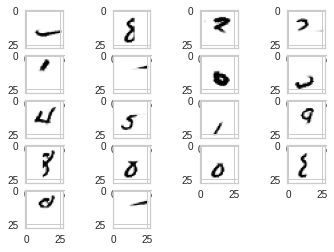

In [26]:
import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(
                                                                                    MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    18,
                                                                                    latent_vectors_visual_concepts,
                                                                                    _exp_config,
                                                                                    _exp_config.dao
                                                                                    )
filename = exp_config.ANALYSIS_PATH + "/" + "cluster_center_lv.pdf"
display_images(decoded_images, filename, None, 18)


# Result of clustering layer 3 feature maps of visual concepts and reconstruing the cluster centers using successive remaining layers of decoder


## Feature maps of layer 3 without concept loss added

In [27]:
import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )


    feature_names_0_10, reconstructed_imges_0_10, feature_dict_0_10  = decode_and_get_features(model,
                                                                                latent_vectors_visual_concepts,
                                                                                exp_config.BATCH_SIZE,
                                                                                3,
                                                                                (0, 10)
                                                                                )


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(1024, 14, 14, 256)
(1024, 14, 14, 256)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 16
in

In [28]:
print([k for k in feature_dict_0_10.keys()])
feature_map_layer_3_0_10 = np.squeeze(feature_dict_0_10["de_conv_3"])
print(feature_map_layer_3_0_10.shape)

['de_conv_3']
(31129, 14, 14, 10)


In [32]:
feature_map_no = 0
feature_map_0_layer_3_0_10_0 = feature_map_layer_3_0_10[:,:,:,feature_map_no]
# feature_map_0_layer_3__0_10__0_reshaped = np.reshape(feature_map_0_layer_3_0_10_0, ( feature_map_0_layer_3_0_10_0.shape[0],
#                                                                    feature_map_0_layer_3_0_10_0.shape[1] * feature_map_0_layer_3_0_10_0.shape[2]
#                                                                    )
# )
cluster_labels_0_10_0, cluster_centers_0_10_0, _, cluster_centers_images_0_10_0 = cluster_gmm(feature_map_0_layer_3_0_10_0,
                                                                                    18
                                                                                    )


In [33]:
cluster_centers_0_10_0.shape

(18, 196)

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis//cluster_center_l3.pdf


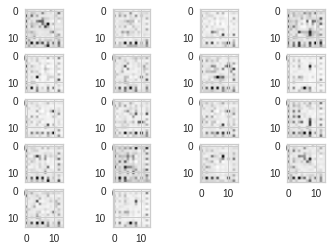

In [34]:
#cluster_centers_images_0_10_0 = np.reshape(cluster_centers_0_10_0, (cluster_centers_0_10_0.shape[0], 14, 14))
display_images(cluster_centers_images_0_10_0, exp_config.ANALYSIS_PATH + "/" +"cluster_center_l3.pdf",None, 18)


Number of image is 31129. Displaying only first 36 images 


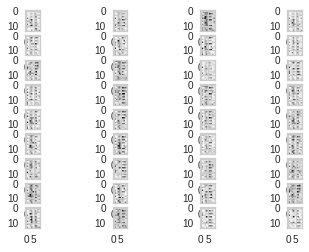

Number of image is 31129. Displaying only first 36 images 


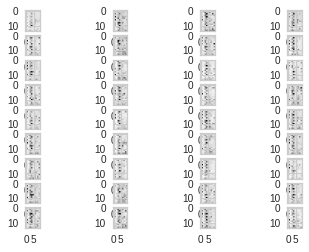

Number of image is 31129. Displaying only first 36 images 


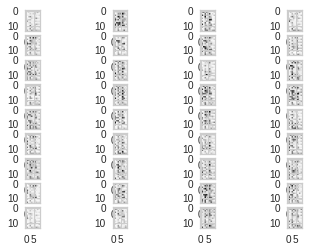

Number of image is 31129. Displaying only first 36 images 


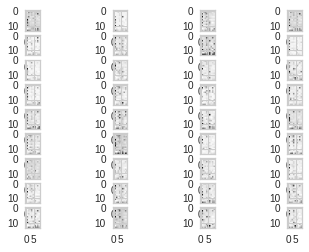

Number of image is 31129. Displaying only first 36 images 


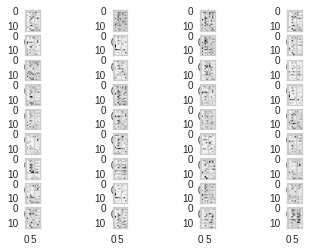

Number of image is 31129. Displaying only first 36 images 


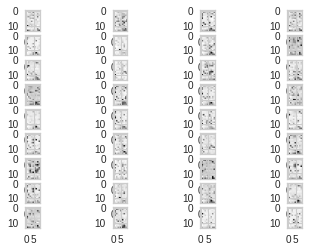

Number of image is 31129. Displaying only first 36 images 


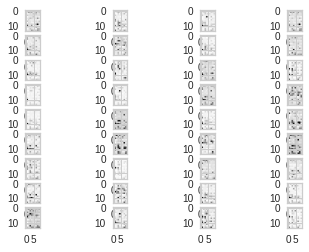

Number of image is 31129. Displaying only first 36 images 


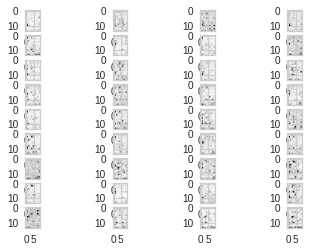

Number of image is 31129. Displaying only first 36 images 


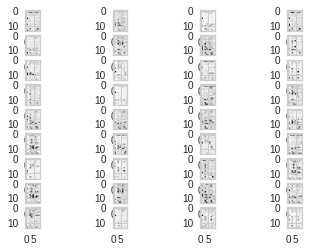

Number of image is 31129. Displaying only first 36 images 


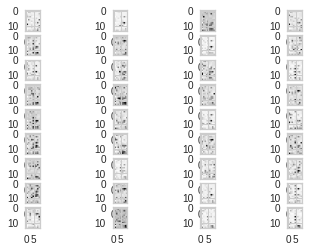

In [35]:
num_concepts = 10
for feature_map_no in range(num_concepts) :
    display_images(feature_map_layer_3_0_10[:, :, feature_map_no], None, None)

# Features of layer 3 feature map 10- 28 - Feature maps with visual concept loss added

In [36]:
import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )

    feature_names_10_28, reconstructed_imges_10_28, feature_dict_10_28  = decode_and_get_features(model,
                                                                                latent_vectors_visual_concepts,
                                                                                exp_config.BATCH_SIZE,
                                                                                3,
                                                                                (10, 28)
                                                                                )


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(1024, 14, 14, 256)
(1024, 14, 14, 256)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (1024, 14, 14, 1)
feature shape (1024, 14, 14, 256)
Computing loss for 3 concept 16
in

In [37]:
print([k for k in feature_dict_10_28.keys()])
feature_map_layer_3_10_28 = np.squeeze(feature_dict_10_28["de_conv_3"])
print(feature_map_layer_3_10_28.shape)

['de_conv_3']
(31129, 14, 14, 18)


In [40]:
feature_map_no = 0
feature_map_layer_3_10_28_0 = feature_map_layer_3_10_28[:, :, :, feature_map_no]
# feature_map_0_layer_3_reshaped = np.reshape(feature_map_layer_3_10_28_0,( feature_map_layer_3_10_28_0.shape[0],
#                                                                    feature_map_layer_3_10_28_0.shape[1] * feature_map_layer_3_10_28_0.shape[2]
#                                                                    ))
cluster_centers_10_28, cluster_labels_10_28, _, cluster_centers_images_10_28 = cluster_gmm(feature_map_layer_3_10_28_0,
                                                                                            18)


Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis//cluster_center_l3_with_loss.pdf


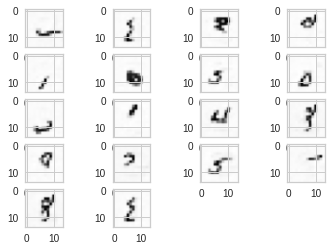

In [41]:
#cluster_centers_images_10_28 = np.reshape(cluster_centers_10_28, (cluster_centers_10_28.shape[0], 14, 14))
display_images(cluster_centers_images_10_28, exp_config.ANALYSIS_PATH + "/" +"cluster_center_l3_with_loss.pdf",None, 18)


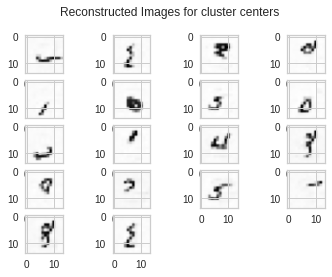

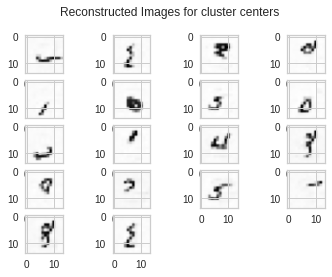

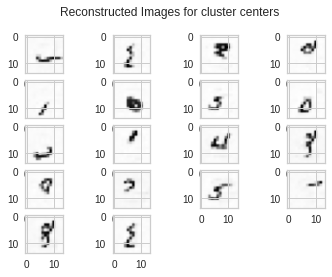

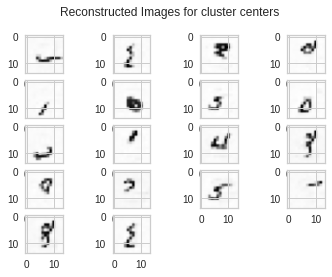

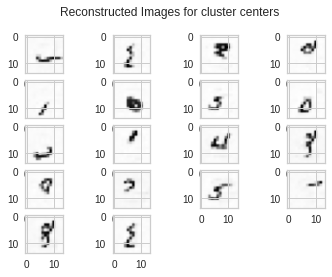

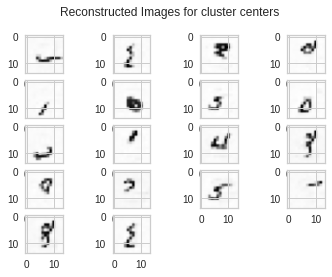

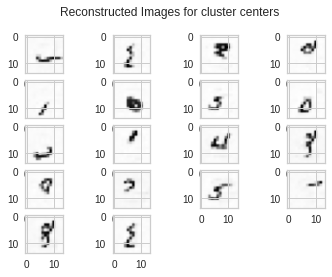

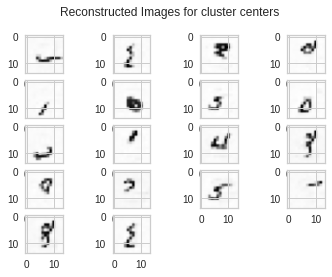

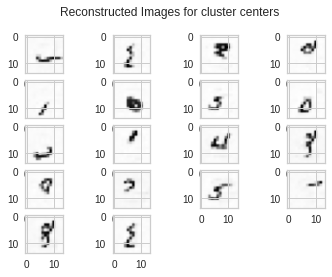

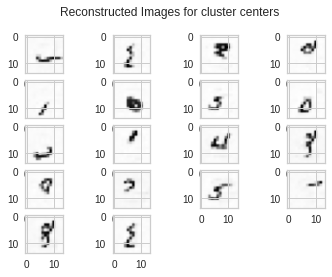

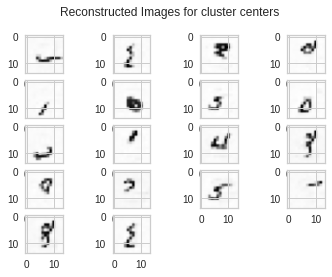

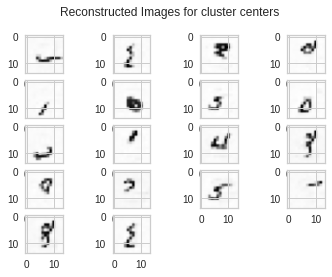

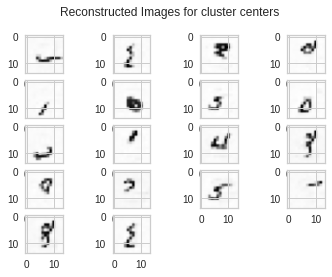

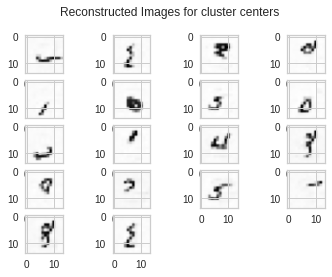

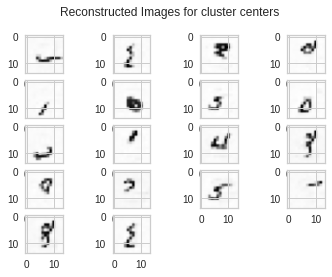

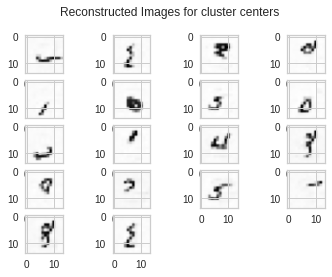

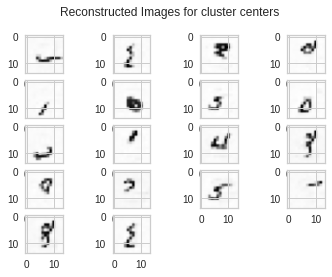

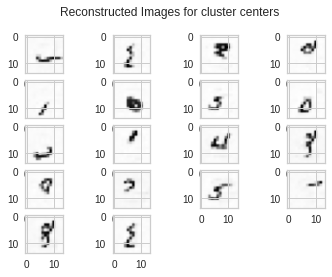

In [43]:
cluster_centers = []
cluster_labels =  []
posterior_proba = []
for feature_map in range(18):
    _feature_map = feature_map_layer_3_10_28[:, :, :, feature_map_no]
    # _feature_map_reshaped = np.reshape(_feature_map,( _feature_map.shape[0],
    #                                                                   _feature_map.shape[1] * _feature_map.shape[2]
    #                                                                   ))
    _cluster_centers, _cluster_labels,_posterior_proba, _cluster_centers_images = cluster_gmm(_feature_map, 18
                                                                                  )
    cluster_centers.append(_cluster_centers)
    cluster_labels.append(_cluster_labels)
    posterior_proba.append(_posterior_proba)

    #_cluster_centers_images = np.reshape(_cluster_centers, (_cluster_centers.shape[0], 14, 14))
    display_images(_cluster_centers_images, None, "Reconstructed Images for cluster centers", 18)



In [ ]:
num_clusters = 18
for concept_no in range(6):
  num_samples_in_cluster =[]
  for i in range(num_clusters):
      num_samples_in_cluster.append( np.sum(cluster_labels[concept_no] == i) )

  print(num_samples_in_cluster)
  plt.figure()
  plt.bar(height=num_samples_in_cluster, x= list(range(0, 18)))
  


In [ ]:
plt.bar(height=num_samples_in_cluster, x= list(range(0,18)))

# Code this below was not used from this file.

# Start segmentation
## Criteria for manual selection
*  Image is straight and vertical
*  All all features clearyly vision

In [ ]:
manual_label_to_cluster_id_map = dict()

for manual_label in manual_labels:
    level_1_clluster = np.where(np.asarray(manual_labels) == manual_label)
    cluster_id = level_1_clluster[0][0]
    manual_label_to_cluster_id_map[manual_label] = cluster_id


In [ ]:
level2_manual_annotations_good_cluster:Dict[int, Dict] = dict()
level2_manual_annotations_good_cluster = cluster_next_level_gmm(_exp_config,
                                                df,
                                                cluster_column_name_2,
                                                df[cluster_column_name],
                                                model_type,
                                                epochs_completed,
                                                _exp_config.dao,
                                                cluster_group_dict,
                                                cluster_type="good_clusters",
                                                num_clusters=20,
                                                show_images=False
                                                )

In [ ]:
image_set_dict = dict()
for cluster_id in range(num_clusters):
    image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = np.asarray(level2_manual_annotations_good_cluster[cluster_id]["decoded_images"])
    image_set_dict[f"training_set_{cluster_id}"] = images_by_label[cluster_id]


In [ ]:
image_list:Dict[int, np.ndarray] = dict()
image_segments:Dict[int, np.ndarray] = dict()

## Digit 8

In [ ]:
digit = 8
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 2
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ 13, 26]
v_extend = [0,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ 0, 15]
v_extend = [0,28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = []
v_extend = [13, 28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_expted = [ ]
v_extend = [0, 13]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 4
7
Image shape (28, 28, 1)
[13, 26] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[0, 15] [0, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [13, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [0, 13] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_8.png


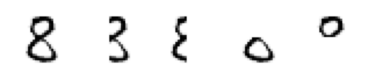

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 7

Number of image is 6248. Displaying only first 36 images 


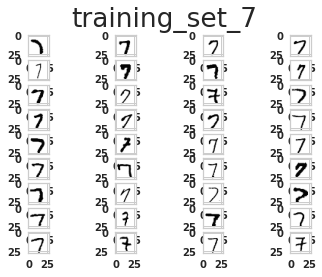

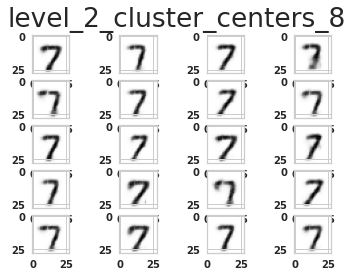

In [ ]:
digit = 7
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
start_index = 0
offset = 2
sample_index = start_index + offset
# cluster_name = "training_set"
#if choosing from cluster, chnage the digit

cluster_name = f"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ ]
v_extend = [12, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_7.png


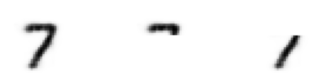

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 6

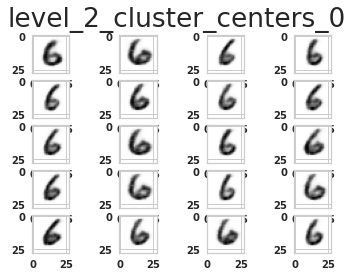

Number of image is 5903. Displaying only first 36 images 


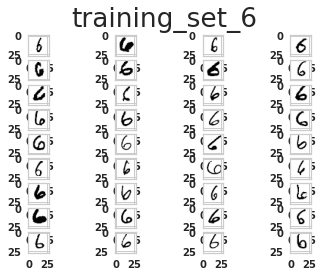

In [ ]:
digit = 6
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )


In [ ]:
offset = 3
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [0,12], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                         cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [12,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [12,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_6.png


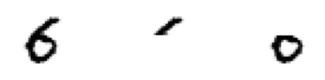

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 5

Number of image is 5405. Displaying only first 36 images 


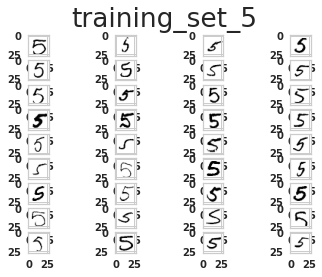

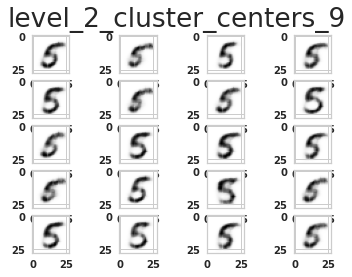

In [ ]:
digit = 5
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5, 11], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                               cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [5, 11]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [11, 28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [11,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 11] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [11, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_5.png


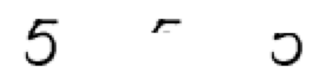

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 4

### 4 has bimodel distribution. So take two samples from each mode

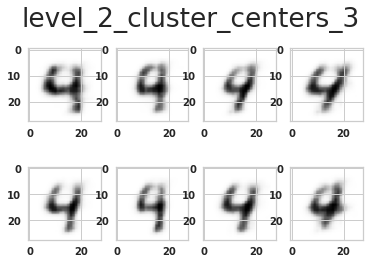

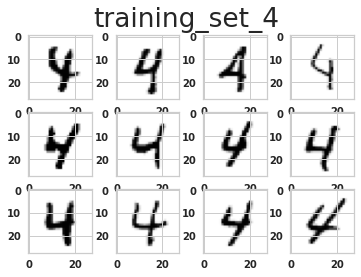

In [ ]:
digit = 4
start_index = 12
NUM_IMAGES_IN_SINGLE_PLOT = 12
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

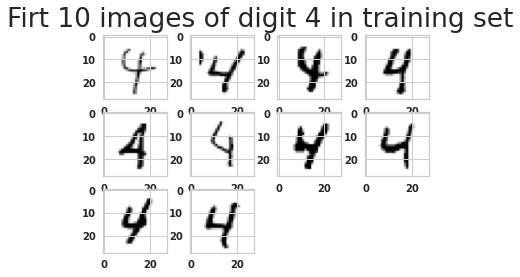

In [ ]:
display_images(images_by_label[digit][10:20,:,:,:], None, f"Firt 10 images of digit {digit} in training set", 10)

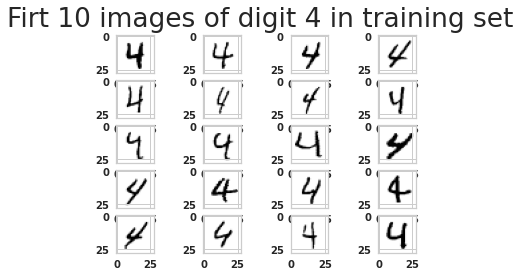

In [ ]:
start_index = 20
display_images(images_by_label[digit][start_index:40,:,:,:], None, f"Firt 10 images of digit {digit} in training set")

In [ ]:
offset = 1
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [15, 18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [15, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# left veritical line
#image_segments = segment( digit_image, h_extend = [13,16 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [13, 16]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# middle veritical line
# image_segments = segment( digit_image, h_extend = [14,17 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [14,17 ]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 3
7
Image shape (28, 28, 1)
[0, 28] [15, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[13, 16] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[14, 17] [0, 28] (28, 28, 1)
14 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_4_training_set_4_21.png


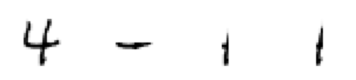

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 4

In [ ]:
#Cleare the previsous image result of 4
image_list[digit] = []

<Figure size 432x288 with 0 Axes>

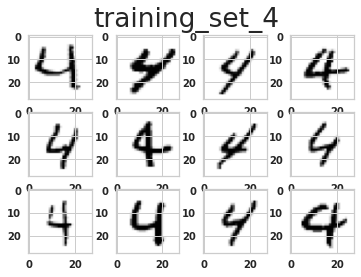

In [ ]:
start_index = 30
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

In [ ]:
offset = 9
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# image_segments = segment( digit_image, h_extend = [ 17,23 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ 17, 23]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[17, 23] [17, 28] (28, 28, 1)
17 14.0 5.6000000000000005
Starts from middle on horizontal axis
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_4_training_set_4_39.png


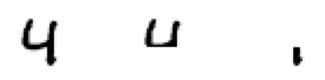

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 3

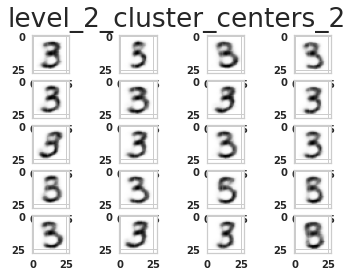

Number of image is 6117. Displaying only first 36 images 


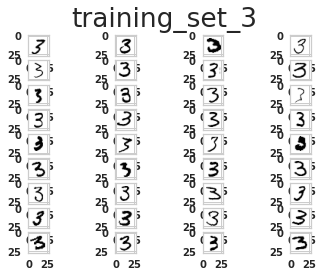

In [ ]:
digit = 3
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [5,16], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 16]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [16,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [16, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 16] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [16, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_3.png


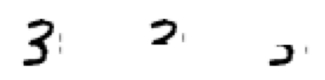

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 2

Number of image is 5940. Displaying only first 36 images 


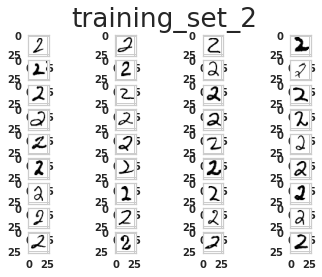

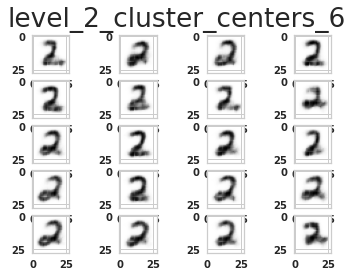

In [ ]:
digit = 2
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

### 2 is bimodal

In [ ]:
offset = 5
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

# Looks like a hook, question mark with dot removed

h_extend = [ ]
v_extend = [3, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [18,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [18, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [18, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_2_training_set_2_5.png


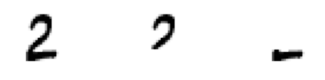

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 2

In [ ]:
#Cleare the previsous image result of 2
image_list[digit] = []

Number of image is 5940. Displaying only first 10 images 


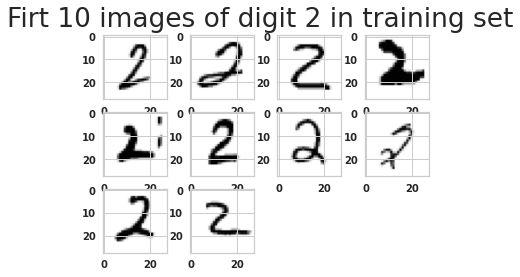

In [ ]:
display_images(images_by_label[digit], None, f"Firt 10 images of digit {digit} in training set", 10)

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
# image_segments = segment( digit_image,
#         h_extend = [],
#         v_extend = [3,15],
#         digit = digit,
#         num_clusters=num_clusters ,
#         exp_config=_exp_config,
#         cluster=cluster_name,
#         sample_index=sample_index
#         )

h_extend = [ ]
v_extend = [3,15]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# image_segments = segment( digit_image,
#                          h_extend = [],
#                          v_extend = [15, 28],
#                          digit = digit,
#                          num_clusters=num_clusters,
#                          exp_config=_exp_config,
#                          cluster=cluster_name,
#                          sample_index=sample_index
#                          )

h_extend = [ ]
v_extend = [15, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 15] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [15, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_2_training_set_2_6.png


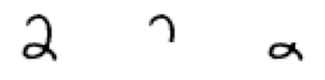

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 9

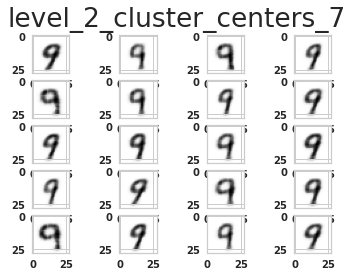

Number of image is 5933. Displaying only first 36 images 


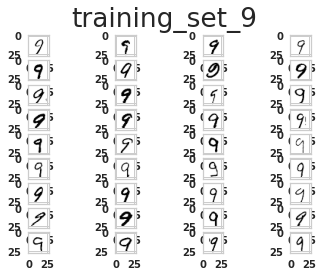

In [ ]:
digit = 9
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,17], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [3, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
#image_segments=segment( digit_image, h_extend = [], v_extend = [17,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [17, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_9.png


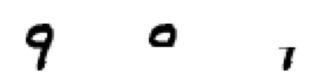

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

# Digit 0

Number of image is 5906. Displaying only first 36 images 


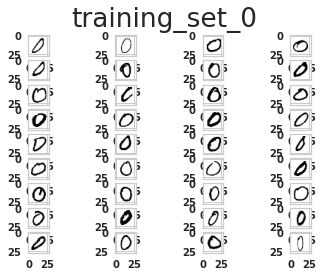

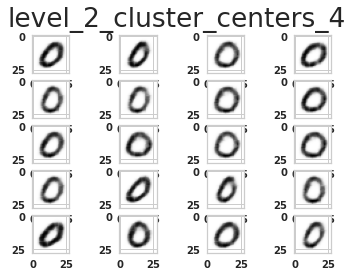

In [ ]:
digit = 0
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

# Reconstruction of segments 

In [ ]:
tf.reset_default_graph()
from copy import copy
image_segments_set_1 = copy(image_segments[2])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[3]])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[4]])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[5]])
#image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[6]])

print(image_segments_set_1.shape)

# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
#     model = get_model(dao = _exp_config.dao,
#                       exp_config=_exp_config,
#                       model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
#                       num_epochs=1,
#                       sess=sess,
#                       test_data_iterator=None,
#                       train_val_data_iterator=None
#                       )
#     mu, sigms, z, features_dict = encode_and_get_features(model,
#                                                           image_segments[8],
#                                                           _exp_config.BATCH_SIZE,
#                                                           _exp_config.Z_DIM
#                                                           )    

# indices_of_similar_images =[0,3,7,9]
# latent_vectors_6_reshaped_similar = latent_vectors_6_reshaped[indices_of_similar_images]
# display_images(latent_vectors_6_reshaped_similar, None, "Latent Images for digit 6", 10)
# display_images(np.squeeze(reconstructed_images_6), None, "Reconstructed image for digit 6", 10)
# for layer_num in range(4):
#   display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,0]),
#                 None,
#                 f"Decoder hidden layer {layer_num} Images for cluster center",
#                 10)


(8, 28, 28, 1)


In [ ]:
# def display_images(decoded_images,
#                    image_filename,
#                    title,
#                    num_images_to_display = 0,
#                    fig_size=None,
#                    axis = None,
#                    num_cols=4,
#                    ):


In [ ]:
file_name = _exp_config.ANALYSIS_PATH  + "manual_concepts_2_6.pdf"

In [ ]:
file_name

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/manual_concepts_2_6.pdf'

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/manual_concepts_2_6.pdf


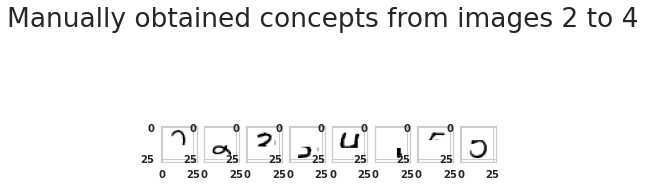

In [ ]:
display_images(image_segments_set_1, file_name, "Manually obtained concepts from images 2 to 4",num_cols=image_segments_set_1.shape[0])

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )    

# indices_of_similar_images =[0,3,7,9]
# latent_vectors_6_reshaped_similar = latent_vectors_6_reshaped[indices_of_similar_images]
# display_images(latent_vectors_6_reshaped_similar, None, "Latent Images for digit 6", 10)
# display_images(np.squeeze(reconstructed_images_6), None, "Reconstructed image for digit 6", 10)
# for layer_num in range(4):
#   display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,0]),
#                 None,
#                 f"Decoder hidden layer {layer_num} Images for cluster center",
#                 10)


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

In [ ]:
reconstructed_images.shape

(4, 28, 28, 1)

In [ ]:
print(z.shape)

(4, 16)


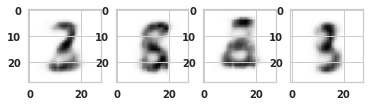

In [ ]:
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

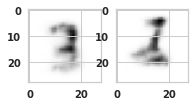

In [ ]:
digit = 2
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

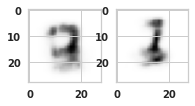

In [ ]:
digit = 2
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

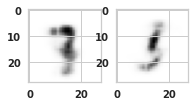

In [ ]:
digit = 3
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

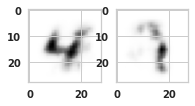

In [ ]:
digit = 4
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

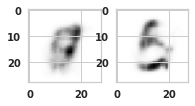

In [ ]:
digit = 5
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

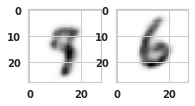

In [ ]:
digit = 6
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

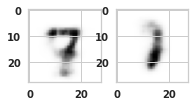

In [ ]:
digit = 7
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)